In [2]:
import numpy as np
import scipy as sp
import math as math
from scipy.optimize import fminbound
import matplotlib.pyplot as plt 
#The Model has this good,y. The consumer can choose to consume y today or invest
#for tomorrow. y = c+i, 
#The production is stochastic, but I will do the model without it for the
#sake of the answer; yet, I'll try to introduce a shock.
#Continuing, the idea i

def bellman_operator(w, grid, b, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    β : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)

    if compute_policy:
        k_prime = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + β E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - b * np.mean(w_func(f(y - c) * shocks))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            k_prime[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, k_prime
    else:
        return Tw

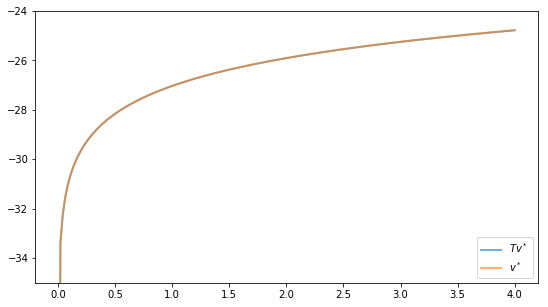

In [19]:
class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^α

    with z ~ LN(μ, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, a=0.4, b=0.96, u=0, s=0.1):

        self.a, self.b, self.u, self.s = a, b, u, s 

        # == Some useful constants == #
        self.ab = a * b
        self.c1 = np.log(1 - self.ab) / (1 - b)
        self.c2 = (u + a * np.log(self.ab)) / (1 - a)
        self.c3 = 1 / (1 - b)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.a

    def f_prime(self, k):
        return self.a * k**(self.a - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.a * self.b) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)
lg = LogLinearOG()
a, b, u, s = lg.a, lg.b, lg.u, lg.s
v_star = lg.v_star
grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(u + s * np.random.randn(shock_size))
w = bellman_operator(v_star(grid),
                     grid,
                     b,
                     np.log,
                     lambda k: k**a,
                     shocks)

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(grid, w, lw=2, alpha=0.6, label='$Tv^*$')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='$v^*$')
ax.legend(loc='lower right')
plt.show()

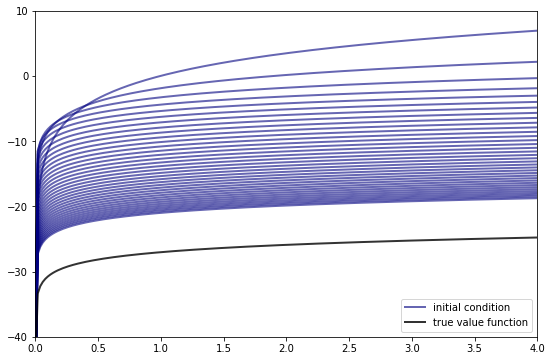

In [21]:
w = 5 * np.log(grid)  # An initial condition
n = 35
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim(-40, 10)
ax.set_xlim(np.min(grid), np.max(grid))
lb = 'initial condition'
ax.plot(grid, w, color=plt.cm.jet(0), lw=2, alpha=0.6, label=lb)
for i in range(n):
    w = bellman_operator(w,
                         grid,
                         b,
                         np.log,
                         lambda k: k**a,
                         shocks)

    ax.plot(grid, w, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

lb = 'true value function'
ax.plot(grid, v_star(grid), 'k-', lw=2, alpha=0.8, label=lb)
ax.legend(loc='lower right')
plt.show()

In [23]:
def solve_optgrowth(initial_w, tol=1e-6, max_iter=500):

    w = initial_w  # Set initial condition
    error = tol + 1
    i = 0

    # == Create storage array for bellman_operator. Reduces  memory
    # allocation and speeds code up == #
    Tw = np.empty(len(grid))

    # Iterate to find solution
    while error > tol and i < max_iter:
        w_new = bellman_operator(w,
                                 grid,
                                 b,
                                 np.log,
                                 lambda k: k**a,
                                 shocks,
                                 Tw)
        error = np.max(np.abs(w_new - w))
        w[:] = w_new
        i += 1

    return w

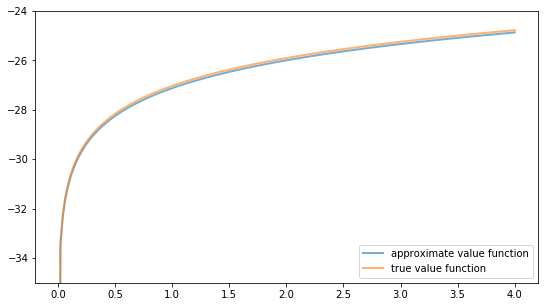

In [24]:
initial_w = 5 * np.log(grid)

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(grid, solve_optgrowth(initial_w), lw=2, alpha=0.6, label='approximate value function')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='true value function')
ax.legend(loc='lower right')
plt.show()

2.7.14


In [1]:
from quantecon import compute_fixed_point

initial_w = 5 * np.log(grid)

# Turn the Bellman operator into a function of one variable
T = lambda w: bellman_operator(w,
                               grid,
                               b,
                               np.log,
                               lambda k: k**a,
                               shocks,
                               compute_policy=False)

v_star_approx = compute_fixed_point(T, initial_w,
                                    error_tol=1e-5,     # error_tol
                                    max_iter=500,       # max_iter
                                    verbose=2,          # verbose
                                    print_skip=10,      # print_skip
                                    method='iteration')

ImportError: No module named quantecon

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(grid, v_star_approx, lw=2, alpha=0.6, label='approximate value function')
ax.plot(grid, v_star(grid), lw=2, alpha=0.6, label='true value function')
ax.legend(loc='lower right')
plt.show()